### To do


> Two datasets "MET-Meme & Memotion" (Multimodal image and text) offensive Meme detection 

> "Multiclass: Not offensive, slight offensive and very offensive" 

> Two Models Models are parallelly work: 
    on text (BERT and CNN) on images (RESNet-152, also comment ResNet-50) 
    Then Dense layer, fully concatenation layer and final multi classification (softmax). 
    Requirement is Dataset should be 7k or more also balance dataset. 
    Accuracy, recall, f1score, precision (validation and training loss graph), 
    (validation and training accuracy graph), (Confusion Matrix)

**Libraries**

In [193]:
rm -rf *pkl

In [194]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from PIL import Image
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import resnet152
from transformers import BertModel, BertTokenizer

## EDA and Preprocessing

### *Dataset Path*

In [195]:
ROOT_PATH = "/kaggle/input/memotion-dataset-7k/memotion_dataset_7k"

In [196]:
data = pd.read_csv(f"{ROOT_PATH}/labels.csv")
# data.drop(columns= ["Unnamed: 0", "text_ocr", "humour", "sarcasm", "motivational", "overall_sentiment"],
#             inplace = True)
# data.columns = ["image_name", "text", "label"]


data.drop(columns= ["Unnamed: 0","text_ocr"], inplace = True)
data.columns = ["image_name", "text", "humour", "sarcasm", 
                "label", "motivational", "overall_sentiment"]

data.head()

,image_name,text,humour,sarcasm,label,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


### Plot Distribution
> Plotting the distribution of Labels

In [197]:
def plot_distribution(df, column_name):
    
    Distribution = df[column_name].value_counts().to_dict()
    categories = list(Distribution.keys())
    values = list(Distribution.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=categories, y=values, palette='Set2')
    for i, v in enumerate(values):
        plt.text(i, v + 50, str(v), ha='center', va='bottom')
    plt.xlabel('Offensiveness Categories')
    plt.ylabel('Frequency')
    plt.title('Frequency of Offensiveness Categories')
    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()



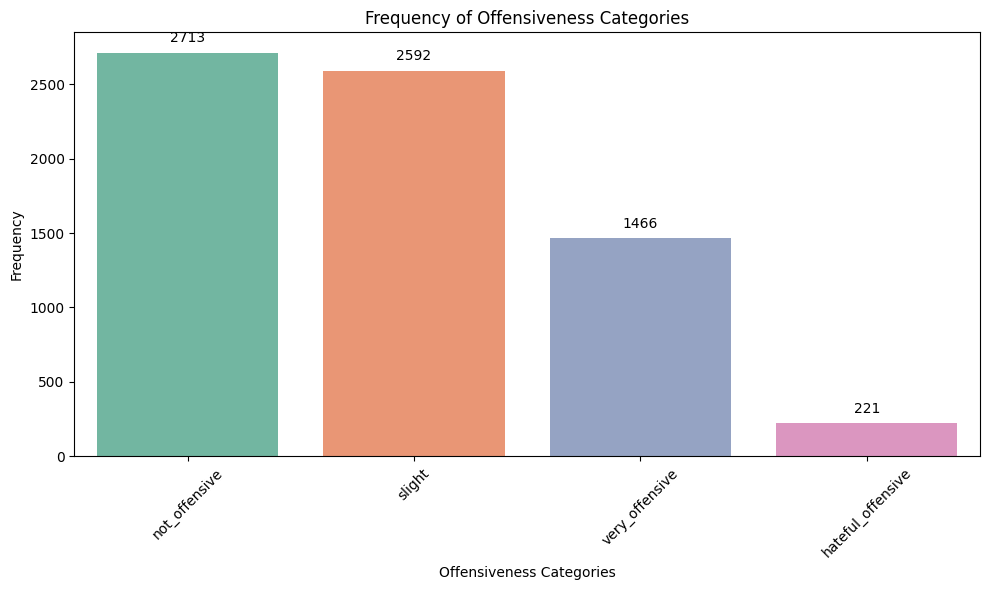

In [198]:
plot_distribution(data, "label")

### Balancing the Dataset

> merged "very_offensive" & "hateful_offensive" as 'very_offensive'

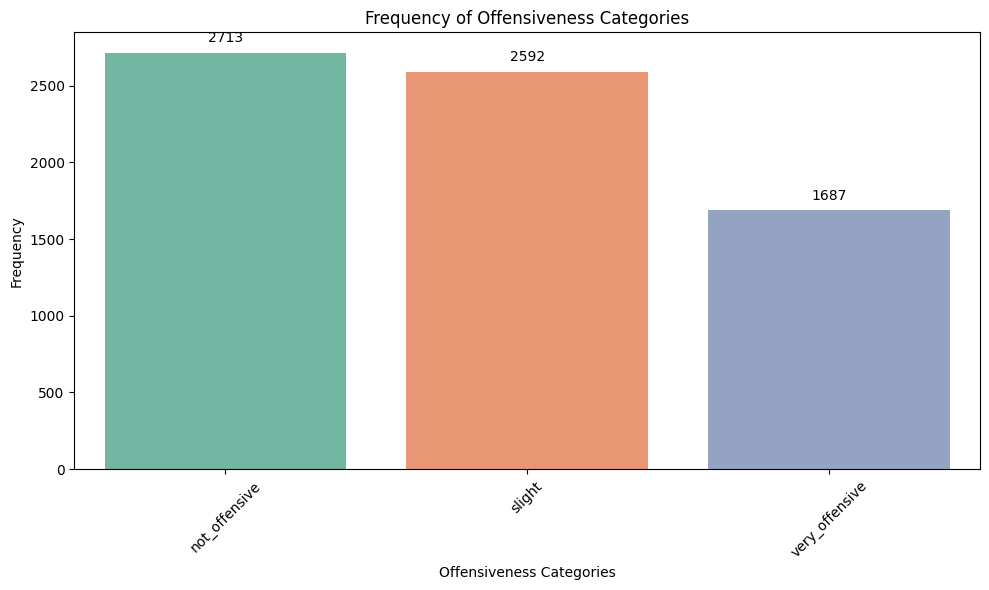

In [199]:
import pandas as pd

# Merge 'very_offensive' and 'hateful_offensive' into one category
data['label'] = data['label'].replace({ 'hateful_offensive': 'very_offensive'})
plot_distribution(data, "label")


### Splitting Data for Training, Validating and Testing

Ensuring Equal Distribution of Labels in Each Subset

In [200]:
from sklearn.model_selection import train_test_split
import numpy as np

X = data.drop(columns = ["label"])
y = data["label"]

# Step 1: Shuffle the dataset
indices = np.arange(len(X))
np.random.shuffle(indices)
X_shuffled = X.iloc[indices]
y_shuffled = y.iloc[indices]

# Step 2: Calculate the percentage of each label
unique_labels, label_counts = np.unique(y_shuffled, return_counts=True)
label_percentages = label_counts / len(y_shuffled)

# Step 3: Split the dataset while maintaining consistent label percentages
# You can adjust the test_size and validation_size as needed
X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.2, stratify=y_shuffled)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

X_train.reset_index(drop=True, inplace = True)
y_train.reset_index(drop=True, inplace = True)

X_validation.reset_index(drop=True, inplace = True)
y_validation.reset_index(drop=True, inplace = True)

X_test.reset_index(drop=True, inplace = True)
y_test.reset_index(drop=True, inplace = True)

# Check label percentages in each set
train_label_percentage = np.unique(y_train, return_counts=True)[1] / len(y_train)
validation_label_percentage = np.unique(y_validation, return_counts=True)[1] / len(y_validation)
test_label_percentage = np.unique(y_test, return_counts=True)[1] / len(y_test)

print("Label percentages in training set:", train_label_percentage)
print("Label percentages in validation set:", validation_label_percentage)
print("Label percentages in test set:", test_label_percentage)


Label percentages in training set: [0.38798498 0.37064187 0.24137315]
Label percentages in validation set: [0.38769671 0.37052933 0.24177396]
Label percentages in test set: [0.38857143 0.37142857 0.24      ]


In [201]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_validation, y_validation], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)


In [202]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         5593 non-null   object
 1   text               5589 non-null   object
 2   humour             5593 non-null   object
 3   sarcasm            5593 non-null   object
 4   motivational       5593 non-null   object
 5   overall_sentiment  5593 non-null   object
 6   label              5593 non-null   object
dtypes: object(7)
memory usage: 306.0+ KB


In [203]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         700 non-null    object
 1   text               699 non-null    object
 2   humour             700 non-null    object
 3   sarcasm            700 non-null    object
 4   motivational       700 non-null    object
 5   overall_sentiment  700 non-null    object
 6   label              700 non-null    object
dtypes: object(7)
memory usage: 38.4+ KB


In [204]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_name         699 non-null    object
 1   text               699 non-null    object
 2   humour             699 non-null    object
 3   sarcasm            699 non-null    object
 4   motivational       699 non-null    object
 5   overall_sentiment  699 non-null    object
 6   label              699 non-null    object
dtypes: object(7)
memory usage: 38.4+ KB


### One Hot Encoding the lables

In [205]:
# Perform one-hot encoding
train_df = pd.get_dummies(train_df, columns=['label'], prefix = "", 
                            prefix_sep = "",dtype = "float32")

val_df = pd.get_dummies(val_df, columns=['label'], prefix = "", 
                            prefix_sep = "",dtype = "float32")

test_df = pd.get_dummies(test_df, columns=['label'], prefix = "", 
                            prefix_sep = "",dtype = "float32")


### Label Encoding

In [206]:
label_encoder = LabelEncoder()

# Apply LabelEncoder to each column
for column in ["humour", "sarcasm", "motivational", "overall_sentiment"]:
    train_df[column] = label_encoder.fit_transform(train_df[column])
    val_df[column] = label_encoder.fit_transform(val_df[column])
    test_df[column] = label_encoder.fit_transform(test_df[column])
    

In [207]:
train_df.head()

,image_name,text,humour,sarcasm,motivational,overall_sentiment,not_offensive,slight,very_offensive
0,image_2032.png,WHAT'S THE DIFFERENCE BETWEEN HILLARY AND PUTI...,3,0,1,2,0.0,1.0,0.0
1,image_5300.png,Anything you photoshop Mr. Bean in makes it hi...,3,0,0,2,0.0,0.0,1.0
2,image_3506.jpg,SO ROMANTIC WOW WOW KISS MUCH LOVE memecrunch.com,0,0,1,0,1.0,0.0,0.0
3,image_2861.jpg,did you know? Because of the way catch rates f...,0,1,1,1,1.0,0.0,0.0
4,image_5643.jpeg,When your parents force you to hug it out with...,3,0,1,2,0.0,1.0,0.0


## Making Dataset 

In [210]:
class MemotionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, image_path: str, tokenizer, transforms, 
                 device :str = "cpu",mode :str = "train", pickle_name :str = "data.pkl"):
        super().__init__()
        self.df = df
        self.imgPath = image_path
        self.tokenizer = tokenizer
        self.transforms = transforms
        self.device = device
        self.image_data = []
        self.pickle_file = mode + "_" + pickle_name

#         If pickle file doesn't exist, preprocess images and save to pickle file
        if not os.path.exists(self.pickle_file):
            self.preprocess_images()
        else:
            with open(self.pickle_file, 'rb') as f:
                self.image_data = pickle.load(f)

    def preprocess_images(self):
        for ix, row in self.df.iterrows():
            image_path = os.path.join(self.imgPath, row['image_name'])
            try:
                img = np.array(Image.open(image_path).convert('RGB'))
                img = self.transforms(img)
                text = str(row['text']).lower()
                out = self.tokenizer(
                    text=text,
                    max_length=124,
                    padding='max_length',
                    truncation=True,
                    return_tensors="pt"
                )
                humour, sarcasm, motivational, overall_sentiment = row[["humour", "sarcasm", "motivational", "overall_sentiment"]]
                label = torch.tensor([row['not_offensive'], row['slight'], row['very_offensive']], dtype=torch.float32)
                self.image_data.append({
                    'image': img,
                    'input_ids': torch.concat([torch.tensor([humour, sarcasm, motivational, overall_sentiment], dtype=torch.long),out['input_ids'].squeeze()]), 
                    'attention_mask': torch.concat([torch.tensor([humour, sarcasm, motivational, overall_sentiment], dtype=torch.long),out['attention_mask'].squeeze()]),
                    'label': label,
                })
            except:
                continue  # Skip

        # Save image data to pickle file
        with open(self.pickle_file, 'wb') as f:
            pickle.dump(self.image_data, f)

    def __len__(self) -> int:
        return len(self.image_data)

    def __getitem__(self, ix: int) -> dict[str, torch.Tensor]:
        data = self.image_data[ix]
        return {
            'image': data['image'].to(self.device),
            'input_ids': data['input_ids'].to(self.device),
            'attention_mask': data['attention_mask'].to(self.device),
            'label': data['label'].to(self.device),
        }


In [218]:
# Define multimodal model
class MultiModalModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiModalModel, self).__init__()
        
        # Text model (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert_out_features = self.bert.config.hidden_size
        
        # Image model (ResNet-152)
        self.resnet = resnet152(pretrained=True)
        
        # Change the output layer to match the BERT output size
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.bert_out_features)
        
        # Final classification layer
        self.fc_layers = nn.Sequential(
            nn.Linear(self.bert_out_features * 2, 128),  # Concatenating BERT and ResNet outputs
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, input_ids, attention_mask, image):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]  # Taking pooled output
        resnet_output = self.resnet(image)
        
        # Concatenate BERT and ResNet outputs
        combined_features = torch.cat((bert_output, resnet_output), dim=1)
        
        # Classification layer
        output = self.fc_layers(combined_features)
        output = F.softmax(output, dim=1)
        
        return output
# import torch.nn as nn
# import torch.nn.functional as F
# from transformers import BertModel
# from torchvision.models import resnet152

# # Define multimodal model
# class MultiModalModel(nn.Module):
#     def __init__(self, num_classes):
#         super(MultiModalModel, self).__init__()
#         # Text model (BERT)
#         self.bert = BertModel.from_pretrained('bert-base-uncased')
#         self.bert_out_features = self.bert.config.hidden_size
        
#         # Image model (ResNet-152)
#         self.resnet = resnet152(pretrained=True)
#         # Change the output layer to match the BERT output size
#         self.resnet.fc = nn.Linear(self.resnet.fc.in_features, self.bert_out_features)
        
#         # CNN layer for text processing
#         self.cnn = nn.Conv1d(in_channels=1, out_channels=self.bert_out_features, kernel_size=3, padding=1)

        
#         # Final classification layers
#         self.fc_layers = nn.Sequential(
#             nn.Linear(self.bert_out_features * 2, 128),  # Concatenating BERT and ResNet outputs
#             nn.LayerNorm(128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.LayerNorm(64),
#             nn.ReLU(),
#             nn.Linear(64, num_classes),
#         )

#     def forward(self, input_ids, attention_mask, image):
#         bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]  # Taking pooled output
#         # Apply CNN to BERT output
#         bert_output = bert_output.unsqueeze(2)  # Add channel dimension
        
#         bert_output = bert_output.permute(0, 2, 1)  # Reshape for Conv1d
        
#         bert_output = F.relu(self.cnn(bert_output))
#         bert_output = bert_output.permute(0, 2, 1)  # Restore original shape
        
#         resnet_output = self.resnet(image)
#         print(bert_output.shape, resnet_output.shape)
#         # Concatenate BERT and ResNet outputs
#         combined_features = torch.cat((bert_output, resnet_output), dim=1)
        
#         # Pass through the sequential layers
#         output = self.fc_layers(combined_features)
        
#         # Apply softmax
#         output = F.softmax(output, dim=1)
        
#         return output


In [219]:

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch in train_loader_iter:
            inputs, attention, images, labels = batch['input_ids'], batch['attention_mask'], batch['image'], batch['label']
            optimizer.zero_grad()
            outputs = model(inputs, attention, images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, 1)).sum().item()
            train_loader_iter.set_postfix({'loss': running_loss / total})
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_loader_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for batch in val_loader_iter:
                inputs, attention, images, labels = batch['input_ids'], batch['attention_mask'], batch['image'], batch['label']
                outputs = model(inputs, attention, images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == torch.argmax(labels, 1)).sum().item()
                val_loader_iter.set_postfix({'loss': loss.item()})
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct / total
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [220]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Initialize transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [221]:
# Data preparation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
IMAGE_PATH = os.path.join(ROOT_PATH, "images")
trainSet = MemotionDataset(train_df,IMAGE_PATH, tokenizer, transform, device,mode = "train")
valSet = MemotionDataset(val_df,IMAGE_PATH, tokenizer, transform, device, mode = "val")
testSet = MemotionDataset(test_df,IMAGE_PATH, tokenizer, transform, device, mode = "test")

# Hyperparameters
num_classes = 3
batch_size = 16
learning_rate = 0.001
num_epochs = 10

# Initialize datasets and loaders
train_loader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valSet, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testSet, batch_size=batch_size, shuffle=False)

cuda


In [222]:
# Initialize model
model = MultiModalModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# model

In [223]:
batch = next(iter(train_loader))
inputs, attention, images, labels = batch['input_ids'], batch['attention_mask'], batch['image'], batch['label']

In [224]:
# Train the model
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

KeyboardInterrupt: 

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accs, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()